In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
import random

In [ ]:
class MultiMNIST(Dataset):
    def __init__(self, mnist_dataset, num_samples=10000, img_size=(32, 64)):
        self.mnist_dataset = mnist_dataset
        self.num_samples = num_samples
        self.img_size = img_size
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)) # MNIST normalization
        ])

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Get two random MNIST images and labels
        idx1, idx2 = random.randint(0, len(self.mnist_dataset) - 1), random.randint(0, len(self.mnist_dataset) - 1)
        img1, label1 = self.mnist_dataset[idx1]
        img2, label2 = self.mnist_dataset[idx2]

        # Convert to PIL Image for easy manipulation
        img1 = transforms.ToPILImage()(img1)
        img2 = transforms.ToPILImage()(img2)

        # Create a new blank image
        new_img = Image.new('L', self.img_size, 0) # 'L' for grayscale, 0 for black background

        # Place images side-by-side with some padding
        # We'll vary the x-position slightly for the second digit to make regression meaningful
        x1_pos = random.randint(0, self.img_size[1] // 2 - img1.width) # Position for first digit
        x2_pos = random.randint(self.img_size[1] // 2, self.img_size[1] - img2.width) # Position for second digit

        new_img.paste(img1, (x1_pos, (self.img_size[0] - img1.height) // 2))
        new_img.paste(img2, (x2_pos, (self.img_size[0] - img2.height) // 2))

        # Apply normalization
        new_img_tensor = self.transform(new_img)

        # Labels for classification and regression
        # Classification labels: [label1, label2]
        # Regression labels: [x1_pos, x2_pos] (normalize them to 0-1 range for better training)
        reg_label1 = x1_pos / (self.img_size[1] - img1.width) # Normalize x1_pos
        reg_label2 = x2_pos / (self.img_size[1] - img2.width) # Normalize x2_pos

        return new_img_tensor, (torch.tensor([label1, label2], dtype=torch.long),
                                torch.tensor([reg_label1, reg_label2], dtype=torch.float))

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 615kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.64MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.36MB/s]


Sample Image Shape: torch.Size([64, 1, 56, 28])
Sample Classification Labels: torch.Size([64, 2])
Sample Regression Labels: torch.Size([64, 2])


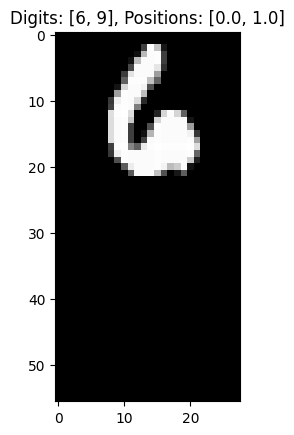

In [ ]:
# Download original MNIST
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Create Multi-MNIST datasets
train_multi_mnist = MultiMNIST(mnist_train, num_samples=20000, img_size=(28, 56)) # Adjusted img_size
test_multi_mnist = MultiMNIST(mnist_test, num_samples=5000, img_size=(28, 56))

train_loader = DataLoader(train_multi_mnist, batch_size=64, shuffle=True)
test_loader = DataLoader(test_multi_mnist, batch_size=64, shuffle=False)

# Verify a sample
sample_img, (sample_cls_labels, sample_reg_labels) = next(iter(train_loader))
print(f"Sample Image Shape: {sample_img.shape}") # Should be [batch_size, 1, 28, 56]
print(f"Sample Classification Labels: {sample_cls_labels.shape}") # Should be [batch_size, 2]
print(f"Sample Regression Labels: {sample_reg_labels.shape}") # Should be [batch_size, 2]

# Display a sample image
plt.imshow(sample_img[0].squeeze().numpy(), cmap='gray')
plt.title(f"Digits: {sample_cls_labels[0].tolist()}, Positions: {sample_reg_labels[0].tolist()}")
plt.show()

In [ ]:
class MultiTaskCNN(nn.Module):
    def __init__(self):
        super(MultiTaskCNN, self).__init__()
        # Feature extractor
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output: 32x14x28

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output: 64x7x14

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # Output: 128x3x7 (approx, depends on exact dimensions)
        )

        # Calculate flattened size: (Input_channels, H, W) -> H_out = (H_in + 2*padding - dilation*(kernel_size-1) - 1)/stride + 1
        # For 28x56 input:
        # 1st MaxPool: 14x28
        # 2nd MaxPool: 7x14
        # 3rd MaxPool: (7/2) rounded up = 4, (14/2) = 7 -> 4x7
        self.flattened_size = 128 * 3 * 7 # (Using floor division for pooling results, so 7/2=3)

        # Classification head (10 classes for each digit)
        self.cls_head = nn.Sequential(
            nn.Linear(self.flattened_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2 * 10) # 2 digits, 10 classes each
        )

        # Regression head (2 coordinates)
        self.reg_head = nn.Sequential(
            nn.Linear(self.flattened_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2) # 2 x-coordinates
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # Flatten
        cls_output = self.cls_head(x)
        reg_output = self.reg_head(x)
        return cls_output, reg_output

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MultiTaskCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
cls_criterion = nn.CrossEntropyLoss()
reg_criterion = nn.MSELoss()

num_epochs = 10 # You can increase this if time permits

def train_model(model, train_loader, optimizer, cls_criterion, reg_criterion, num_epochs, device):
    model.train()
    for epoch in range(num_epochs):
        total_cls_loss = 0
        total_reg_loss = 0
        for batch_idx, (data, (cls_labels, reg_labels)) in enumerate(train_loader):
            data, cls_labels, reg_labels = data.to(device), cls_labels.to(device), reg_labels.to(device)

            optimizer.zero_grad()
            cls_output, reg_output = model(data)

            # Calculate classification loss for both digits
            cls_loss1 = cls_criterion(cls_output[:, :10], cls_labels[:, 0])
            cls_loss2 = cls_criterion(cls_output[:, 10:], cls_labels[:, 1])
            classification_loss = cls_loss1 + cls_loss2

            # Calculate regression loss for both coordinates
            regression_loss = reg_criterion(reg_output, reg_labels)

            # Combine losses (you can weight them if one task is more important)
            total_loss = classification_loss + regression_loss

            total_loss.backward()
            optimizer.step()

            total_cls_loss += classification_loss.item()
            total_reg_loss += regression_loss.item()

            if batch_idx % 100 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, "
                      f"Cls Loss: {classification_loss.item():.4f}, Reg Loss: {regression_loss.item():.4f}")

        avg_cls_loss = total_cls_loss / len(train_loader)
        avg_reg_loss = total_reg_loss / len(train_loader)
        print(f"Epoch {epoch+1} finished. Avg Cls Loss: {avg_cls_loss:.4f}, Avg Reg Loss: {avg_reg_loss:.4f}")

train_model(model, train_loader, optimizer, cls_criterion, reg_criterion, num_epochs, device)

Using device: cpu
Epoch 1/10, Batch 0/313, Cls Loss: 4.6016, Reg Loss: 0.4463
Epoch 1/10, Batch 100/313, Cls Loss: 2.6814, Reg Loss: 0.0171
Epoch 1/10, Batch 200/313, Cls Loss: 2.6891, Reg Loss: 0.0120
Epoch 1/10, Batch 300/313, Cls Loss: 2.5154, Reg Loss: 0.0162
Epoch 1 finished. Avg Cls Loss: 2.8783, Avg Reg Loss: 0.0181
Epoch 2/10, Batch 0/313, Cls Loss: 2.4484, Reg Loss: 0.0142
Epoch 2/10, Batch 100/313, Cls Loss: 2.3972, Reg Loss: 0.0100
Epoch 2/10, Batch 200/313, Cls Loss: 2.4338, Reg Loss: 0.0107
Epoch 2/10, Batch 300/313, Cls Loss: 2.4236, Reg Loss: 0.0152
Epoch 2 finished. Avg Cls Loss: 2.4268, Avg Reg Loss: 0.0103
Epoch 3/10, Batch 0/313, Cls Loss: 2.3691, Reg Loss: 0.0082
Epoch 3/10, Batch 100/313, Cls Loss: 2.3588, Reg Loss: 0.0080
Epoch 3/10, Batch 200/313, Cls Loss: 2.4098, Reg Loss: 0.0062
Epoch 3/10, Batch 300/313, Cls Loss: 2.3840, Reg Loss: 0.0054
Epoch 3 finished. Avg Cls Loss: 2.3932, Avg Reg Loss: 0.0077
Epoch 4/10, Batch 0/313, Cls Loss: 2.3197, Reg Loss: 0.0047
E

Test Accuracy for Digit 1: 99.10%
Test Accuracy for Digit 2: 11.40%
Average Regression MSE: 0.0000


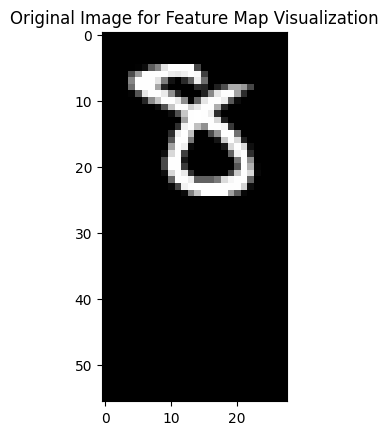

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [ ]:
def evaluate_model(model, test_loader, device):
    model.eval()
    correct_cls1 = 0
    correct_cls2 = 0
    total_samples = 0
    total_reg_error = 0

    with torch.no_grad():
        for data, (cls_labels, reg_labels) in test_loader:
            data, cls_labels, reg_labels = data.to(device), cls_labels.to(device), reg_labels.to(device)
            cls_output, reg_output = model(data)

            # Classification accuracy
            _, predicted_cls1 = torch.max(cls_output[:, :10], 1)
            _, predicted_cls2 = torch.max(cls_output[:, 10:], 1)

            correct_cls1 += (predicted_cls1 == cls_labels[:, 0]).sum().item()
            correct_cls2 += (predicted_cls2 == cls_labels[:, 1]).sum().item()
            total_samples += cls_labels.size(0)

            # Regression error (MSE for simplicity)
            total_reg_error += ((reg_output - reg_labels)**2).sum().item()

    print(f"Test Accuracy for Digit 1: {(100 * correct_cls1 / total_samples):.2f}%")
    print(f"Test Accuracy for Digit 2: {(100 * correct_cls2 / total_samples):.2f}%")
    print(f"Average Regression MSE: {(total_reg_error / (total_samples * 2)):.4f}") # Divide by 2 coordinates

evaluate_model(model, test_loader, device)


# Feature Map Visualization (Example for a single image)
def visualize_feature_maps(model, image_tensor, layer_index=0):
    model.eval()
    # Ensure the image tensor is unsqueezed to be (1, C, H, W)
    image_tensor = image_tensor.unsqueeze(0).to(device)

    # Get the output of the specified convolutional layer
    activation = model.features[layer_index](image_tensor)

    # Move to CPU and convert to numpy
    activation = activation.squeeze().cpu().numpy()

    num_filters = activation.shape[0]
    fig, axes = plt.subplots(1, min(num_filters, 8), figsize=(15, 2)) # Show up to 8 filters

    for i in range(min(num_filters, 8)):
        ax = axes[i]
        ax.imshow(activation[i], cmap='viridis')
        ax.axis('off')
        ax.set_title(f'Filter {i+1}')
    plt.suptitle(f"Feature Maps from Layer {layer_index+1}")
    plt.show()

# Get a sample image from the test set
sample_img_for_viz, _ = test_multi_mnist[0]
plt.imshow(sample_img_for_viz.squeeze().numpy(), cmap='gray')
plt.title("Original Image for Feature Map Visualization")
plt.show()

# Visualize feature maps after the first convolutional layer
visualize_feature_maps(model, sample_img_for_viz, layer_index=0)
# Visualize feature maps after the second convolutional layer (index 3 in Sequential)
visualize_feature_maps(model, sample_img_for_viz, layer_index=3)

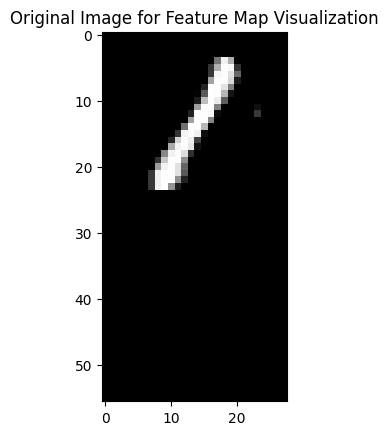

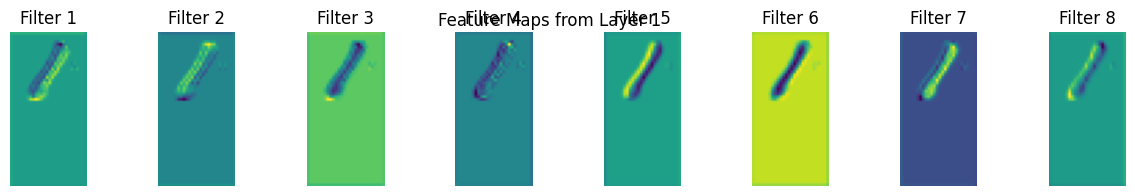

RuntimeError: Given groups=1, weight of size [64, 32, 3, 3], expected input[1, 1, 56, 28] to have 32 channels, but got 1 channels instead

In [8]:
# Feature Map Visualization (Example for a single image)
def visualize_feature_maps(model, image_tensor, layer_index=0):
    model.eval()
    # Ensure the image tensor is unsqueezed to be (1, C, H, W)
    image_tensor = image_tensor.unsqueeze(0).to(device)

    # Get the output of the specified convolutional layer
    # To access specific layers within `nn.Sequential`, you can index it
    # For example, model.features[0] for the first Conv2d layer
    # model.features[1] for the first ReLU, etc.
    # The layer_index should correspond to the index within the 'features' Sequential block.
    # For Conv2d layers, they are at indices 0, 3, 6 (if you follow the definition provided)
    # The error came from trying to call .numpy() on the output of a layer
    # that still potentially holds gradient information from the forward pass.

    # We need to ensure that when we get the activation for visualization,
    # it's not tracking gradients. We are already in model.eval() and
    # ideally, we should wrap the call with torch.no_grad(), but sometimes intermediate
    # tensors still carry gradient info if the input to the model wasn't detached.

    # The most robust way is to specifically detach the activation before converting to numpy.

    with torch.no_grad(): # Ensure no gradients are computed for visualization
        activation = model.features[layer_index](image_tensor)

    # Move to CPU, detach from the computation graph, and then convert to numpy
    activation = activation.squeeze().cpu().detach().numpy()

    num_filters = activation.shape[0]
    fig, axes = plt.subplots(1, min(num_filters, 8), figsize=(15, 2)) # Show up to 8 filters

    for i in range(min(num_filters, 8)):
        ax = axes[i]
        ax.imshow(activation[i], cmap='viridis')
        ax.axis('off')
        ax.set_title(f'Filter {i+1}')
    plt.suptitle(f"Feature Maps from Layer {layer_index+1}")
    plt.show()

# Get a sample image from the test set
sample_img_for_viz, _ = test_multi_mnist[0]
plt.imshow(sample_img_for_viz.squeeze().numpy(), cmap='gray')
plt.title("Original Image for Feature Map Visualization")
plt.show()

# Visualize feature maps after the first convolutional layer (index 0 in model.features)
visualize_feature_maps(model, sample_img_for_viz, layer_index=0)
# Visualize feature maps after the second convolutional layer (index 3 in model.features)
visualize_feature_maps(model, sample_img_for_viz, layer_index=3)

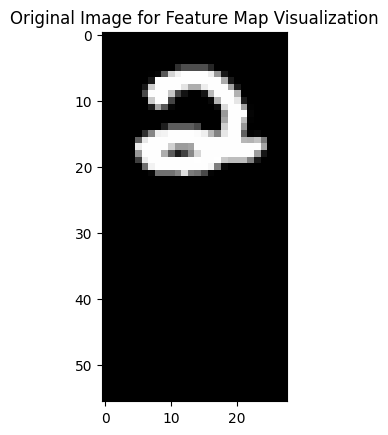

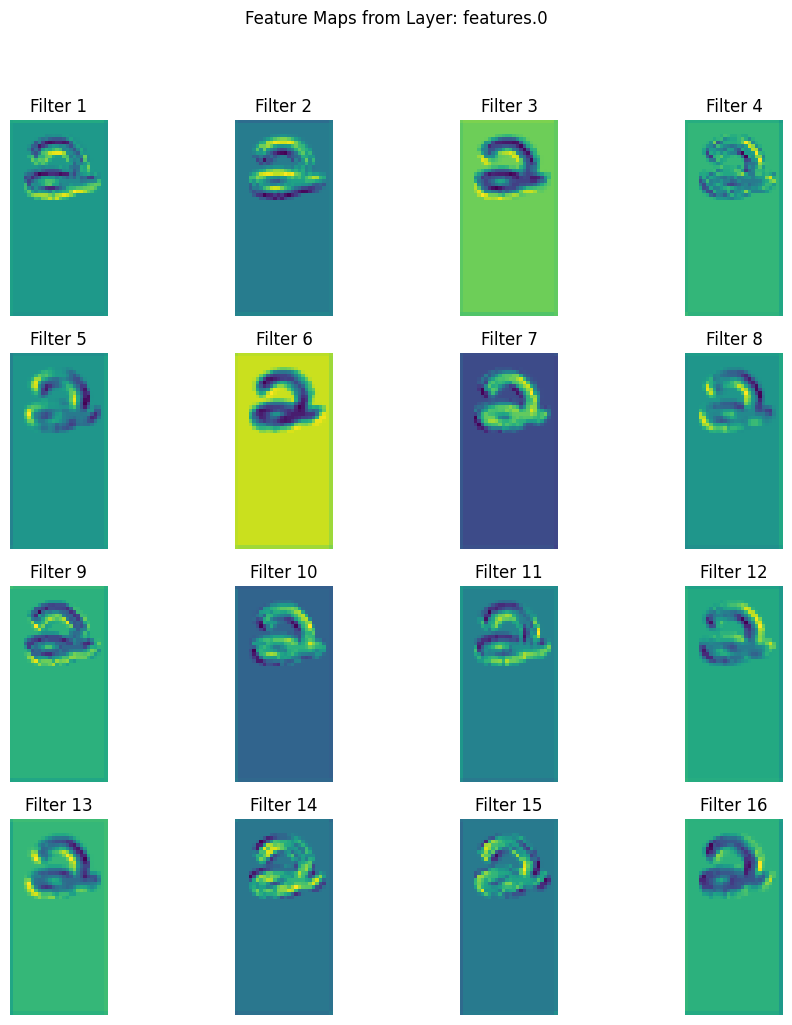

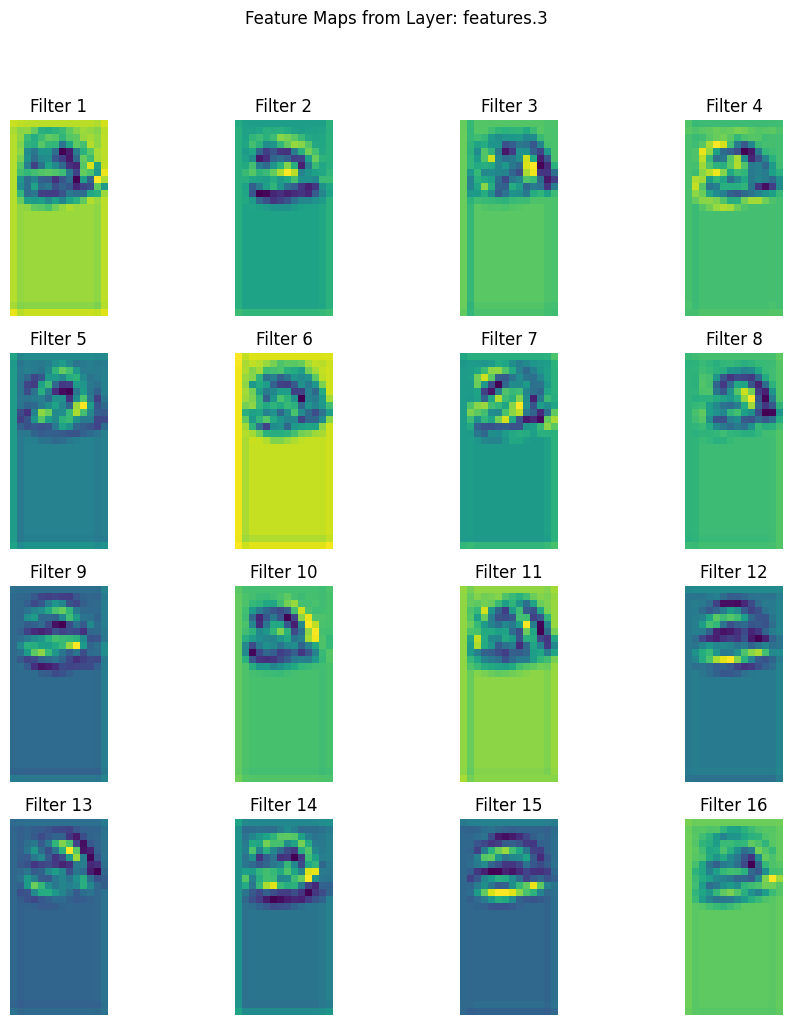

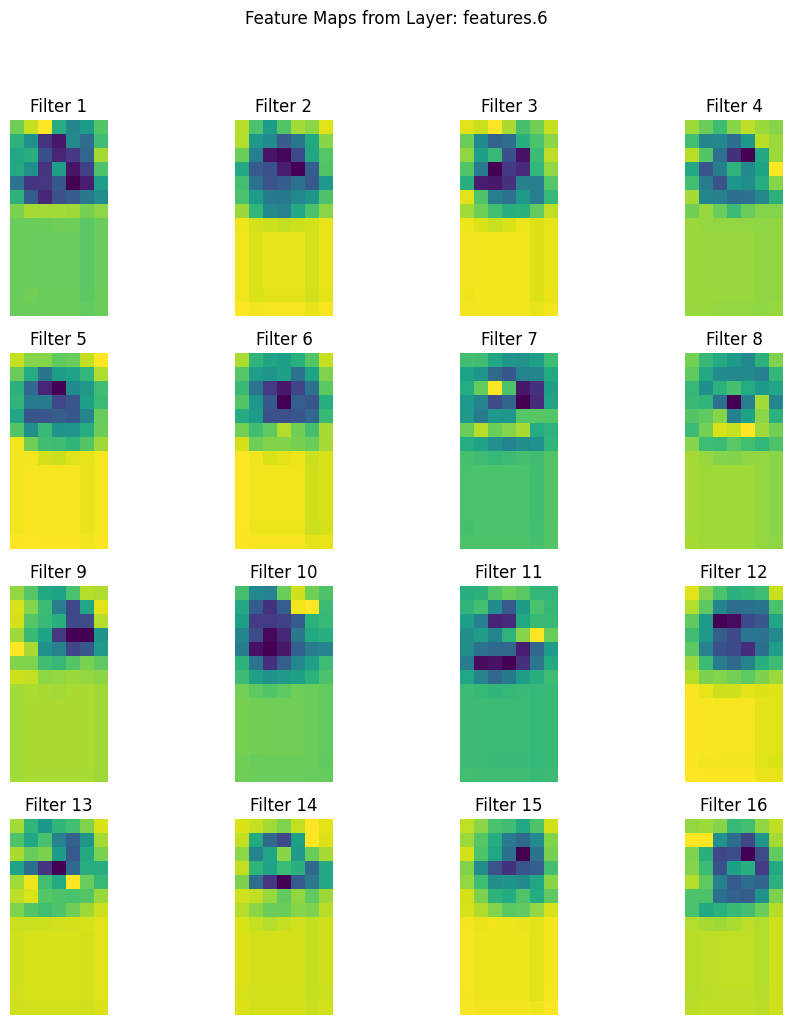

In [9]:
# Feature Map Visualization (Example for a single image)
def visualize_feature_maps(model, image_tensor, layer_name='features.0'): # Modified to take layer_name
    model.eval()
    image_tensor = image_tensor.unsqueeze(0).to(device)

    # To visualize feature maps, we need to pass the image through the network
    # up to the desired layer.
    activations = []

    # Define a hook to capture the output of the desired layer
    # We'll create a list to hold the activation
    hook_handle = None

    def hook_fn(module, input, output):
        activations.append(output)

    # Register the hook on the specific layer
    # layer_name can be 'features.0' for the first conv layer, 'features.3' for the second, etc.
    target_layer = None

    # Dynamically find the layer based on layer_name (e.g., 'features.0')
    parts = layer_name.split('.')
    current_module = model
    for part in parts:
        if part.isdigit():
            current_module = current_module[int(part)]
        else:
            current_module = getattr(current_module, part)

    hook_handle = current_module.register_forward_hook(hook_fn)

    with torch.no_grad():
        # Pass the input through the full model's feature extractor
        _ = model.features(image_tensor) # We run the forward pass to trigger the hook

    # Remove the hook
    hook_handle.remove()

    if not activations:
        print(f"No activations captured for layer: {layer_name}. Check layer_name.")
        return

    activation = activations[0] # Get the captured activation

    # Move to CPU, detach from the computation graph, and then convert to numpy
    activation = activation.squeeze().cpu().detach().numpy()

    # If the activation is 3D (CxHxW), then it's a stack of feature maps
    if activation.ndim == 3:
        num_filters = activation.shape[0]
        # Adjust layout for displaying square feature maps from rectangular input
        fig_rows = int(np.ceil(np.sqrt(min(num_filters, 16)))) # Try to make it somewhat square
        fig_cols = int(np.ceil(min(num_filters, 16) / fig_rows))

        fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(fig_cols * 2.5, fig_rows * 2.5))
        axes = axes.flatten() # Flatten for easy iteration

        for i in range(min(num_filters, len(axes))): # Show up to num_filters or available axes
            ax = axes[i]
            ax.imshow(activation[i], cmap='viridis')
            ax.axis('off')
            ax.set_title(f'Filter {i+1}')
        # Hide any unused subplots
        for i in range(min(num_filters, len(axes)), len(axes)):
            axes[i].axis('off')

    # If the activation is 2D (HxW), it might be a single feature map or flattened
    elif activation.ndim == 2:
        plt.figure(figsize=(5, 5))
        plt.imshow(activation, cmap='viridis')
        plt.axis('off')
        plt.title(f'Feature Map from {layer_name}')
    else:
        print(f"Unexpected activation shape: {activation.shape}")
        return

    plt.suptitle(f"Feature Maps from Layer: {layer_name}", y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to prevent title overlap
    plt.show()

# Get a sample image from the test set
sample_img_for_viz, _ = test_multi_mnist[0]
plt.imshow(sample_img_for_viz.squeeze().numpy(), cmap='gray')
plt.title("Original Image for Feature Map Visualization")
plt.show()

# Visualize feature maps after the first convolutional layer (features[0])
visualize_feature_maps(model, sample_img_for_viz, layer_name='features.0')
# Visualize feature maps after the second convolutional layer (features[3])
visualize_feature_maps(model, sample_img_for_viz, layer_name='features.3')
# Visualize feature maps after the third convolutional layer (features[6])
visualize_feature_maps(model, sample_img_for_viz, layer_name='features.6')

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # Normalize to [-1, 1] for better autoencoder performance
])

fashion_mnist_train = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
fashion_mnist_test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader_fm = DataLoader(fashion_mnist_train, batch_size=128, shuffle=True)
test_loader_fm = DataLoader(fashion_mnist_test, batch_size=128, shuffle=False)

100%|██████████| 26.4M/26.4M [00:01<00:00, 14.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 232kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 4.28MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.4MB/s]


In [12]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1), # Output: 16x14x14
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # Output: 32x7x7
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=7) # Output: 64x1x1 (bottleneck, compressed representation)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=7), # Output: 32x7x7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), # Output: 16x14x14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1), # Output: 1x28x28
            nn.Tanh() # Use Tanh to match the [-1, 1] normalization
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

autoencoder = Autoencoder().to(device)
ae_optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
ae_criterion = nn.MSELoss()

ae_num_epochs = 10 # You can increase this

def train_autoencoder(model, train_loader, optimizer, criterion, num_epochs, device):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader): # We only need the image data
            data = data.to(device)

            optimizer.zero_grad()
            reconstructed_data = model(data)
            loss = criterion(reconstructed_data, data) # Compare input to output

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            if batch_idx % 100 == 0:
                print(f"AE Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, "
                      f"Loss: {loss.item():.4f}")

        avg_loss = total_loss / len(train_loader)
        print(f"AE Epoch {epoch+1} finished. Avg Loss: {avg_loss:.4f}")

train_autoencoder(autoencoder, train_loader_fm, ae_optimizer, ae_criterion, ae_num_epochs, device)

Using device: cpu
AE Epoch 1/10, Batch 0/469, Loss: 0.5555
AE Epoch 1/10, Batch 100/469, Loss: 0.1178
AE Epoch 1/10, Batch 200/469, Loss: 0.0801
AE Epoch 1/10, Batch 300/469, Loss: 0.0746
AE Epoch 1/10, Batch 400/469, Loss: 0.0558
AE Epoch 1 finished. Avg Loss: 0.1067
AE Epoch 2/10, Batch 0/469, Loss: 0.0541
AE Epoch 2/10, Batch 100/469, Loss: 0.0475
AE Epoch 2/10, Batch 200/469, Loss: 0.0472
AE Epoch 2/10, Batch 300/469, Loss: 0.0437
AE Epoch 2/10, Batch 400/469, Loss: 0.0380
AE Epoch 2 finished. Avg Loss: 0.0452
AE Epoch 3/10, Batch 0/469, Loss: 0.0381
AE Epoch 3/10, Batch 100/469, Loss: 0.0398
AE Epoch 3/10, Batch 200/469, Loss: 0.0362
AE Epoch 3/10, Batch 300/469, Loss: 0.0363
AE Epoch 3/10, Batch 400/469, Loss: 0.0331
AE Epoch 3 finished. Avg Loss: 0.0360
AE Epoch 4/10, Batch 0/469, Loss: 0.0310
AE Epoch 4/10, Batch 100/469, Loss: 0.0284
AE Epoch 4/10, Batch 200/469, Loss: 0.0306
AE Epoch 4/10, Batch 300/469, Loss: 0.0337
AE Epoch 4/10, Batch 400/469, Loss: 0.0293
AE Epoch 4 finis

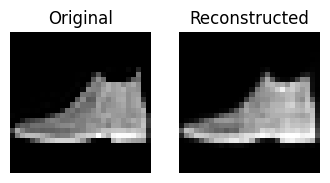

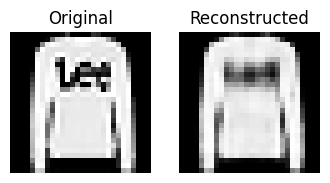

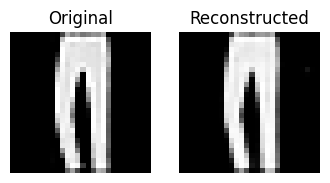

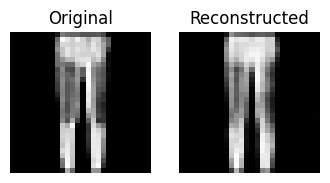

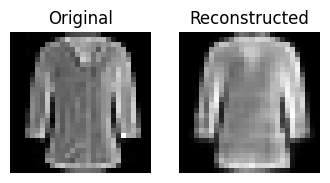

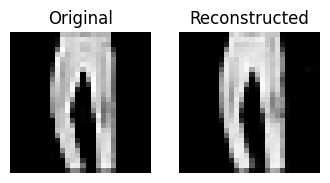

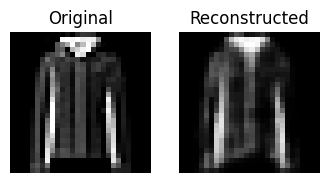

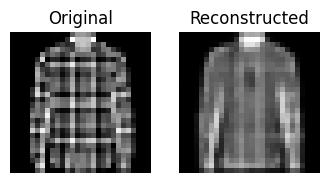

Shape of a single latent vector: (64,)
Example latent vector (first 5 elements): [-4.583617    1.471407    0.85727894 -0.6937888  -0.46443984]


In [14]:
def visualize_autoencoder_results(model, test_loader, device, num_images=10):
    model.eval()
    data_iter = iter(test_loader)
    with torch.no_grad():
        for _ in range(num_images // test_loader.batch_size + 1): # Get enough batches
            data, _ = next(data_iter)
            data = data.to(device)
            reconstructed_data = model(data)

            # Move to CPU and denormalize for display
            original_images = (data.cpu().numpy() * 0.5 + 0.5).clip(0, 1) # Denormalize from [-1, 1] to [0, 1]
            reconstructed_images = (reconstructed_data.cpu().numpy() * 0.5 + 0.5).clip(0, 1)

            for i in range(min(num_images, data.size(0))):
                plt.figure(figsize=(4, 2))
                plt.subplot(1, 2, 1)
                plt.imshow(original_images[i].squeeze(), cmap='gray')
                plt.title('Original')
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.imshow(reconstructed_images[i].squeeze(), cmap='gray')
                plt.title('Reconstructed')
                plt.axis('off')
                plt.show()
            if data.size(0) >= num_images:
                break

visualize_autoencoder_results(autoencoder, test_loader_fm, device, num_images=8)


# How to demonstrate dimensionality reduction:
# You can get the latent space representation (output of the encoder)
# and then perhaps use PCA or t-SNE to visualize clusters in that space.
# For a quick demonstration, just show the shape of the encoded vector.

def get_latent_representation(model, data_loader, device, num_samples=5):
    model.eval()
    latent_vectors = []
    labels = []
    with torch.no_grad():
        for i, (data, label) in enumerate(data_loader):
            if i * data.size(0) >= num_samples:
                break
            data = data.to(device)
            latent = model.encoder(data)
            latent_vectors.append(latent.cpu().numpy().reshape(latent.size(0), -1)) # Flatten the latent space
            labels.append(label.cpu().numpy())
    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels = np.concatenate(labels, axis=0)
    print(f"Shape of a single latent vector: {latent_vectors[0].shape}")
    print(f"Example latent vector (first 5 elements): {latent_vectors[0, :5]}")
    return latent_vectors, labels

latent_vecs, fm_labels = get_latent_representation(autoencoder, test_loader_fm, device, num_samples=100)

# You could then use something like this to visualize (requires matplotlib and sklearn.manifold.TSNE)
# from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2, random_state=42)
# latent_tsne = tsne.fit_transform(latent_vecs)

# plt.figure(figsize=(10, 8))
# plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=fm_labels, cmap='tab10', s=10)
# plt.colorbar()
# plt.title('t-SNE visualization of Autoencoder Latent Space (Fashion-MNIST)')
# plt.show()